In [16]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster.hierarchy import dendrogram
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import cluster_jzar
import climb_jor

In [2]:
pd.set_option("display.max_columns",None)
pd.set_option('display.max_rows', 10)

### We have 3 types of data:
- `Independent features (clustered)` => <b>In this notebook we will work on this one
- How good the route is (the higher the better)
- Grade, Location, sex, heigh (defined by user)


# Clustering Routes

First we retrieve the features dataframe

In [3]:
routes_features = pd.read_csv('../data/routes_features.csv',low_memory=False, index_col=0)

In [4]:
print(routes_features.shape)
routes_features.tail(5)

(54958, 17)


,name_id,country,crag,sector,name,ascents_count,repeat_sum,recommend_sum,chiped_sum,soft_sum,hard_sum,traditional_sum,tall_recommend_sum,grade_mean,sentiment_mean,rating_mean,sex_ratio
54953,54953,zaf,van stadens,the beach,bouche,2,0.0,0.0,0.0,0,0,0,0,36.0,0.0,1.0,0.0
54954,54954,zaf,van stadens,the beach,bush biscuit,2,0.0,1.0,0.0,0,0,0,0,44.0,NaN,NaN,0.0
54955,54955,zaf,van stadens,the beach,funky chicken,2,0.0,0.0,0.0,0,0,0,0,38.0,0.0,1.0,0.0
54956,54956,zaf,van stadens,the beach,out of control,2,0.0,0.0,0.0,0,0,0,0,36.0,NaN,NaN,0.0
54957,54957,zaf,van stadens,the beach,sheathless,2,0.0,0.0,0.0,0,1,0,-1,39.5,0.0,2.0,0.0


## Prepare the dataframe for clustering

In [8]:
# Drop not interesting features
X = routes_features[['ascents_count','repeat_sum','chiped_sum','soft_sum','hard_sum','traditional_sum','tall_recommend_sum','sex_ratio']]

In [10]:
X.corr()

,ascents_count,repeat_sum,chiped_sum,soft_sum,hard_sum,traditional_sum,tall_recommend_sum,sex_ratio
ascents_count,1.000000,0.317007,0.083922,0.726802,0.571535,0.045131,0.072101,0.043563
repeat_sum,0.317007,1.000000,0.015749,0.196039,0.157989,0.090865,0.043159,-0.000830
chiped_sum,0.083922,0.015749,1.000000,0.087597,0.071401,-0.005930,0.014513,-0.024628
soft_sum,0.726802,0.196039,0.087597,1.000000,0.213415,0.003243,0.128758,0.001916
hard_sum,0.571535,0.157989,0.071401,0.213415,1.000000,0.023637,-0.036253,-0.003109
traditional_sum,0.045131,0.090865,-0.005930,0.003243,0.023637,1.000000,-0.002962,-0.006533
tall_recommend_sum,0.072101,0.043159,0.014513,0.128758,-0.036253,-0.002962,1.000000,0.004233
sex_ratio,0.043563,-0.000830,-0.024628,0.001916,-0.003109,-0.006533,0.004233,1.000000


<AxesSubplot:>

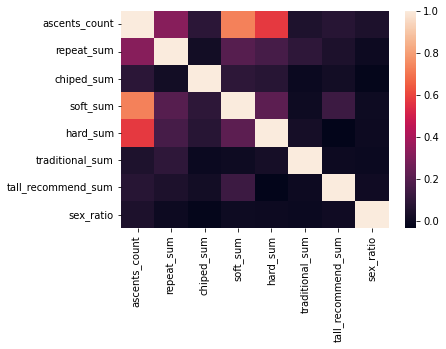

In [11]:
sns.heatmap(X.corr())

In [12]:
X

,ascents_count,repeat_sum,chiped_sum,soft_sum,hard_sum,traditional_sum,tall_recommend_sum,sex_ratio
0,6,0.0,0.0,1,1,0,-1,0.0
1,5,0.0,0.0,0,0,0,0,0.0
2,4,0.0,0.0,0,1,0,-1,0.0
3,3,0.0,0.0,0,1,0,0,0.0
4,2,0.0,0.0,1,0,0,1,0.0
...,...,...,...,...,...,...,...,...
54953,2,0.0,0.0,0,0,0,0,0.0
54954,2,0.0,0.0,0,0,0,0,0.0
54955,2,0.0,0.0,0,0,0,0,0.0
54956,2,0.0,0.0,0,0,0,0,0.0


In [13]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
filename = "../transformer/scaler.pickle" # Path with filename
with open(filename, "wb") as file:
        pickle.dump(scaler,file)
X_scaled_df = pd.DataFrame(X_scaled, columns = X.columns)
print(X_scaled_df.shape)
display(X_scaled_df.head(3))

(54958, 8)


,ascents_count,repeat_sum,chiped_sum,soft_sum,hard_sum,traditional_sum,tall_recommend_sum,sex_ratio
0,-0.239496,-0.219239,-0.113951,0.034615,0.180577,-0.098288,-1.059134,-0.614671
1,-0.284042,-0.219239,-0.113951,-0.342769,-0.425404,-0.098288,-0.024677,-0.614671
2,-0.328587,-0.219239,-0.113951,-0.342769,0.180577,-0.098288,-1.059134,-0.614671


### Check the PCA

In [14]:
pca = PCA(n_components=None)
principalComponents = pca.fit_transform(X_scaled_df)
principalDf = pd.DataFrame(data = principalComponents)
pca.explained_variance_ratio_

array([0.27530541, 0.1311877 , 0.12941618, 0.12722394, 0.11961733,
       0.10405559, 0.09275519, 0.02043866])

# Clustering model - K-Means

In [17]:
# K = range(2, 21)
# inertia = []
# silhouette = []

# for k in K:
#     print("Training a K-Means model with {} neighbours! ".format(k))
#     print()
#     kmeans = KMeans(n_clusters=k,
#                     random_state=1234)
#     kmeans.fit(X_scaled_df)
#     filename = "../model/kmeans_" + str(k) + ".pickle" # Path with filename
#     with open(filename, "wb") as file:
#         pickle.dump(kmeans,file)
#     inertia.append(kmeans.inertia_)
#     silhouette.append(silhouette_score(X_scaled_df, kmeans.predict(X_scaled_df)))

Training a K-Means model with 2 neighbours! 

Training a K-Means model with 3 neighbours! 

Training a K-Means model with 4 neighbours! 

Training a K-Means model with 5 neighbours! 

Training a K-Means model with 6 neighbours! 

Training a K-Means model with 7 neighbours! 

Training a K-Means model with 8 neighbours! 

Training a K-Means model with 9 neighbours! 

Training a K-Means model with 10 neighbours! 

Training a K-Means model with 11 neighbours! 

Training a K-Means model with 12 neighbours! 

Training a K-Means model with 13 neighbours! 

Training a K-Means model with 14 neighbours! 

Training a K-Means model with 15 neighbours! 

Training a K-Means model with 16 neighbours! 

Training a K-Means model with 17 neighbours! 

Training a K-Means model with 18 neighbours! 

Training a K-Means model with 19 neighbours! 

Training a K-Means model with 20 neighbours! 



I will 3D plot in 2 groups


Text(0.5, 1.0, 'Silhouette Method showing the optimal k')

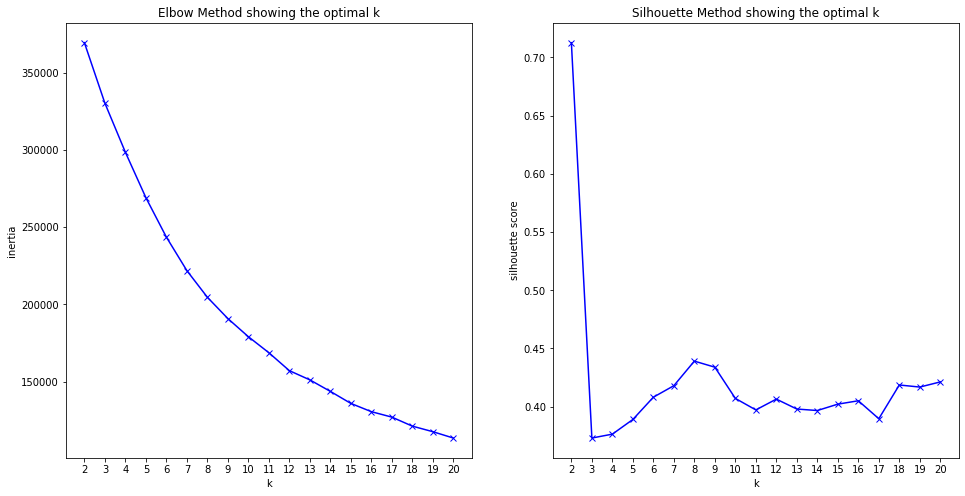

In [18]:
fig, ax = plt.subplots(1,2,figsize=(16,8))
ax[0].plot(K, inertia, 'bx-')
ax[0].set_xlabel('k')
ax[0].set_ylabel('inertia')
ax[0].set_xticks(np.arange(min(K), max(K)+1, 1.0))
ax[0].set_title('Elbow Method showing the optimal k')
ax[1].plot(K, silhouette, 'bx-')
ax[1].set_xlabel('k')
ax[1].set_ylabel('silhouette score')
ax[1].set_xticks(np.arange(min(K), max(K)+1, 1.0))
ax[1].set_title('Silhouette Method showing the optimal k')

We see a relatively good score for 8

In [21]:
k = 8
filename = "../model/kmeans_" + str(k) + ".pickle" # Path with filename
with open(filename, "rb") as file:
    kmeans = pickle.load(file)
clusters = kmeans.predict(X_scaled_df)
#clusters
pd.Series(clusters).value_counts().sort_index() # Number of songs in each cluster

0    37955
1      320
2       42
3     1962
4     8593
5      633
6     1096
7     4357
dtype: int64

In [22]:
clusters

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

### Check the PCA

In [23]:
pca = PCA(n_components=None)
principalComponents = pca.fit_transform(X_scaled_df)
principalDf = pd.DataFrame(data = principalComponents)
pca.explained_variance_ratio_

array([0.27530541, 0.1311877 , 0.12941618, 0.12722394, 0.11961733,
       0.10405559, 0.09275519, 0.02043866])

I will 3D plot in 2 groups... the limited human brain..

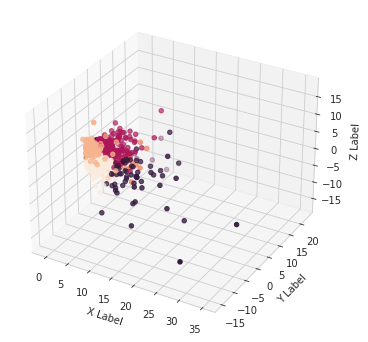

In [24]:
from plot_jzar import *
# %matplotlib notebook
plot3D(x = principalDf[0],y = principalDf[1],z = principalDf[2],color = clusters, fraction = 0.2)

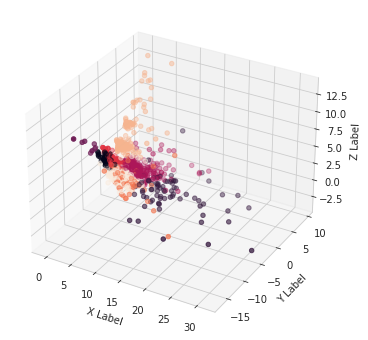

In [28]:
# %matplotlib notebook
plot3D(x = principalDf[0],y = principalDf[2],z = principalDf[4],color = clusters, fraction = 0.2)

And we see that the assigned clusters are not so bad

### Assing each route to a cluster

In [29]:
X_cl = routes_features.copy()
X_cl["cluster"] = pd.Series(clusters)

In [33]:
routes_clustered = X_cl.drop(columns = ['chiped_sum','soft_sum','hard_sum','traditional_sum','sex_ratio'])
print(routes_clustered.shape)
routes_clustered.head()

(54958, 13)


,name_id,country,crag,sector,name,ascents_count,repeat_sum,recommend_sum,tall_recommend_sum,grade_mean,sentiment_mean,rating_mean,cluster
0,0,and,montserrat,prohibitivo,el mehir,6,0.0,1.0,-1,49.000000,0.0,2.00,0
1,1,and,montserrat,prohibitivo,el pas de la discordia,5,0.0,1.0,0,49.000000,0.0,1.75,0
2,2,and,montserrat,prohibitivo,la x,4,0.0,0.0,-1,49.250000,0.0,2.00,0
3,3,and,tartareu,bombo suis,tenedor libre,3,0.0,1.0,0,44.333333,0.0,3.00,0
4,4,arg,bandurrias,rincon,tendinitis,2,0.0,0.0,1,48.500000,0.0,1.00,0


In [34]:
clust_0 = routes_clustered[routes_clustered.cluster == 0]

In [35]:
routes_clustered.cluster.value_counts()

0    37955
4     8593
7     4357
3     1962
6     1096
5      633
1      320
2       42
Name: cluster, dtype: int64

In [36]:
routes_clustered.to_csv('../data/routes_clustered.csv')